# Machine Learning Practical: Movie Recommendation System

**Author:** Nicolas Baskiotis (nicolas.baskiotis@sorbonne-universite.fr)  
**Institution:** MLIA/ISIR, Sorbonne Université

---

## Overview

This practical aims to revisit fundamental Machine Learning concepts through a concrete application: the **movie recommendation problem**. 
The recommendation problem was popularized by the famous Netflix Challenge in the late 2000s. Typically, such problems involve:
- A set of **users**
- A set of **items** (movies in our case)
- Information about them (user profiles, item features, user ratings on items)
- **Goal:** Predict ratings of new users on items (or users on new items)

Recommendation systems are used in numerous applications: e-commerce sites, social networks (suggesting friends, articles of interest), etc.

We will work with data from the **MovieLens project** (https://movielens.org/): recommendation data on users and movies.

In this practical, we will consider a simpler problem: predicting the average rating of a movie across all users. This will allow us to review the standard methodology of a machine learning problem: processing data, evaluating models, and choosing the right algorithm among the main Machine Learning algorithms.

---

## Practical Structure

1. **Data Exploration and Preprocessing**
2. **Regression - Score Prediction**
3. **Binary Classification and Metrics**
4. **Methodology and Validation**

---

## Required Libraries

You will use the following Python modules: `sklearn`, `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, roc_curve, auc)
from scipy.stats import spearmanr

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

/home/baskiotisn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

# Section 1: Data Exploration and Preprocessing

## Dataset

Download the data from: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip (We will work with the **ml-latest-small.zip** file - 700 users, 9000 movies - of the https://grouplens.org/datasets/movielens/ site).



The archive contains:
- `movies.csv`: movie information (ID, title, genres among 22 categories)
- `ratings.csv`: ratings given by users


---

Before anything else, it is very important in a Data Science problem to understand the data you are dealing with. The first step is to perform an Exploratory Data Analysis (EDA), which involves studying the statistical properties of the data: histograms, correlations, amplitudes, ranges, etc. It may be necessary to transform the data (pre-processing) to scale it or eliminate certain dimensions. This first section illustrates in a simplified version this preliminary work.

### Question 1.1: Load and Explore the Data

Run the cells below to load the data, then answer the questions.

**Step 1: Load the raw data**

We load two CSV files:
- `movies.csv`: contains movie information (ID, title, genres)
- `ratings.csv`: contains user ratings (userId, movieId, rating from 0.5 to 5.0)

**Step 2: Build the rating matrix**

The **rating matrix** is a 2D representation where:
- Rows = movies
- Columns = users
- Values = ratings (0 if the user hasn't rated the movie)

This matrix is typically very **sparse** (mostly zeros) because users only rate a small fraction of available movies.

**Step 3: Build movie features**

For machine learning, we need to represent each movie as a **feature vector**. We extract:
- **Year**: extracted from the title (e.g., "Toy Story (1995)" → 1995)
- **Genres**: converted to binary columns (one-hot encoding). Example: a Comedy+Romance movie → [Comedy=1, Romance=1, Action=0, ...]
- **Rating statistics**: number of ratings and average rating per movie

**Your tasks:**
1. Observe the structure of the two dataframes (`movies` and `ratings`)
2. Calculate the sparsity of the rating matrix (percentage of empty cells)


In [2]:
# ==================================================
# STEP 1: Load raw data
# ==================================================

movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

print("=" * 50)
print("MOVIES dataset")
print("=" * 50)
print(movies.head())
print(f"\nShape: {movies.shape} (rows x columns)")

print("\n" + "=" * 50)
print("RATINGS dataset")
print("=" * 50)
print(ratings.head())
print(f"\nShape: {ratings.shape} (rows x columns)")
print(f"  -> Each row = one rating from one user on one movie")

MOVIES dataset
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Shape: (9742, 3) (rows x columns)

RATINGS dataset
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Shape: (100836, 4) (rows x columns)
  -> Each row = one rating from one user on one movie


In [3]:
# ==================================================
# STEP 2: Build the rating matrix
# ==================================================
# pivot_table transforms the long format (one row per rating) 
# into a matrix format (rows=movies, columns=users)
# fill_value=0 means "no rating" is represented as 0

rating_matrix = ratings.pivot_table(index='movieId', columns='userId', values='rating', fill_value=0)

print(f"Rating matrix shape: {rating_matrix.shape}")
print(f"Number of movies: {rating_matrix.shape[0]}")
print(f"Number of users: {rating_matrix.shape[1]}")

# TODO: Calculate the sparsity (percentage of zeros in the matrix)
# Sparsity = (number of zeros) / (total cells) * 100
# Hint: use (rating_matrix == 0).sum().sum() to count zeros


n_zeros = (rating_matrix == 0).sum().sum()
total_cells = rating_matrix.shape[0] * rating_matrix.shape[1]
sparsity = (n_zeros / total_cells) * 100

print(f"\nSparsity: {sparsity:.2f}%")

Rating matrix shape: (9724, 610)
Number of movies: 9724
Number of users: 610

Sparsity: 98.30%


In [4]:
# ==================================================
# STEP 3: Build movie feature matrix
# ==================================================
# Each movie will be described by a feature vector for ML

# --- Extract year from title ---
# Example: "Toy Story (1995)" -> 1995
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
movies['year'] = movies['year'].fillna(movies['year'].median())  # Fill missing years with median

# --- Binarize genres (one-hot encoding) ---
# Example: "Comedy|Romance" -> Comedy=1, Romance=1, Action=0, Drama=0, ...
genres_split = movies['genres'].str.get_dummies(sep='|')
genres_split.index = movies['movieId']

# --- Compute rating statistics per movie ---
rating_count = ratings.groupby('movieId').size().rename('rating_count')  # How many ratings?
rating_mean = ratings.groupby('movieId')['rating'].mean().rename('rating_mean')  # Average rating?

# --- Combine all features into one dataframe ---
movie_features = pd.concat([
    movies[['movieId', 'year']].set_index('movieId'),
    genres_split,
    rating_count,
    rating_mean
], axis=1)

movie_features = movie_features.fillna(0)  # Fill missing values with 0

print(f"Movie features shape: {movie_features.shape}")
print(f"  -> {movie_features.shape[0]} movies")
print(f"  -> {movie_features.shape[1]} features per movie")
print(f"\nFeature columns: {list(movie_features.columns)}")
print("\nFirst few rows:")
print(movie_features.head())

Movie features shape: (9742, 23)
  -> 9742 movies
  -> 23 features per movie

Feature columns: ['year', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'rating_count', 'rating_mean']

First few rows:
           year  (no genres listed)  Action  Adventure  Animation  Children  \
movieId                                                                       
1        1995.0                   0       0          1          1         1   
2        1995.0                   0       0          1          0         1   
3        1995.0                   0       0          0          0         0   
4        1995.0                   0       0          0          0         0   
5        1995.0                   0       0          0          0         0   

         Comedy  Crime  Documentary  Drama  ...  IMAX  Musical  My

### Question 1.2: Data Statistics

**Your tasks:**
1. Calculate the mean and median number of ratings per user
2. Calculate the mean and median number of ratings per movie
3. Run the visualization cells and observe the distributions

**Questions to answer:**
- Are ratings uniformly distributed across users and movies?
- What does this imply for building a recommendation system?

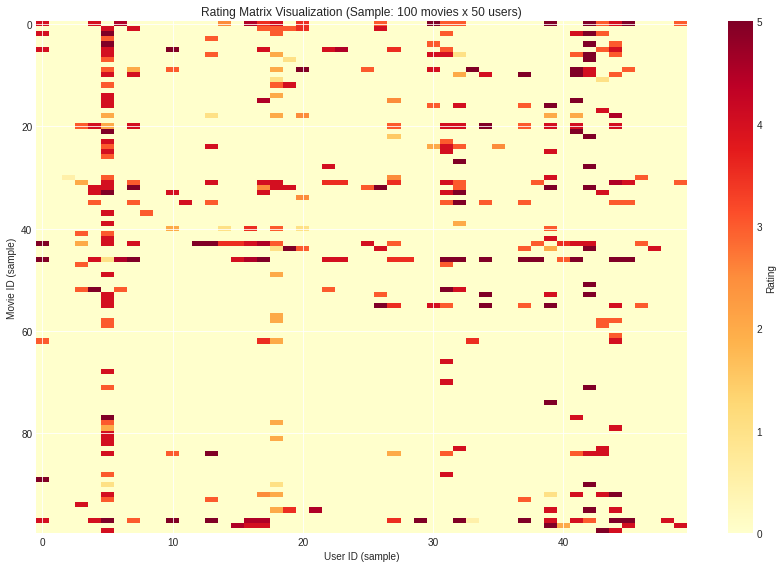

Matrix sparsity (zeros): 98.30%


In [5]:
# Visualize rating matrix (sample)
plt.figure(figsize=(12, 8))
sample_matrix = rating_matrix.iloc[:100, :50]  # Sample for visualization
plt.imshow(sample_matrix, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Rating')
plt.xlabel('User ID (sample)')
plt.ylabel('Movie ID (sample)')
plt.title('Rating Matrix Visualization (Sample: 100 movies x 50 users)')
plt.tight_layout()
plt.show()

print(f"Matrix sparsity (zeros): {(rating_matrix == 0).sum().sum() / rating_matrix.size:.2%}")

Ratings per user:
  Mean: 165.30
  Median: 70.50
  Min: 20, Max: 2698


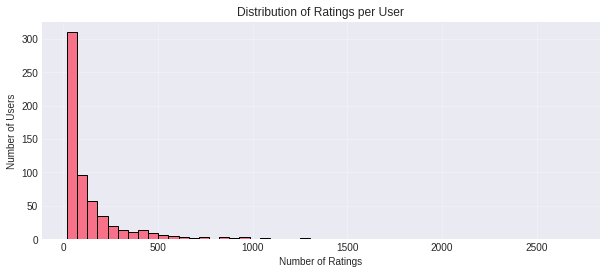

In [6]:
# Number of ratings per user
ratings_per_user = ratings.groupby('userId').size()

# TODO: Calculate mean and median ratings per user


mean_ratings_user = ratings_per_user.mean()
median_ratings_user = ratings_per_user.median()

print(f"Ratings per user:")
print(f"  Mean: {mean_ratings_user:.2f}")
print(f"  Median: {median_ratings_user:.2f}")
print(f"  Min: {ratings_per_user.min()}, Max: {ratings_per_user.max()}")

# Visualization (provided)
plt.figure(figsize=(10, 4))
plt.hist(ratings_per_user, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Distribution of Ratings per User')
plt.grid(alpha=0.3)
plt.show()

Ratings per movie:
  Mean: 10.37
  Median: 3.00
  Min: 1, Max: 329

Movies with < 10 ratings: 7455 (76.67%)


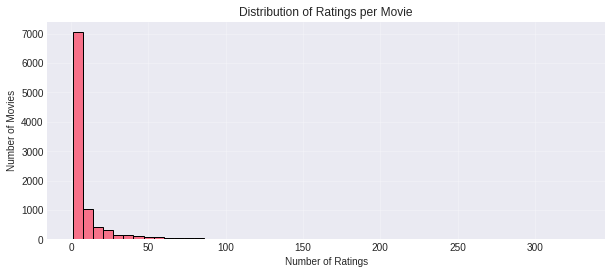

In [7]:
# Number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()

# TODO: Calculate mean and median ratings per movie


mean_ratings_movie = ratings_per_movie.mean()
median_ratings_movie = ratings_per_movie.median()

print(f"Ratings per movie:")
print(f"  Mean: {mean_ratings_movie:.2f}")
print(f"  Median: {median_ratings_movie:.2f}")
print(f"  Min: {ratings_per_movie.min()}, Max: {ratings_per_movie.max()}")

# TODO: Calculate percentage of movies with less than 10 ratings


movies_few_ratings = (ratings_per_movie < 10).sum()
pct_few_ratings = movies_few_ratings / len(ratings_per_movie) * 100

print(f"\nMovies with < 10 ratings: {movies_few_ratings} ({pct_few_ratings:.2f}%)")

# Visualization (provided)
plt.figure(figsize=(10, 4))
plt.hist(ratings_per_movie, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings per Movie')
plt.grid(alpha=0.3)
plt.show()

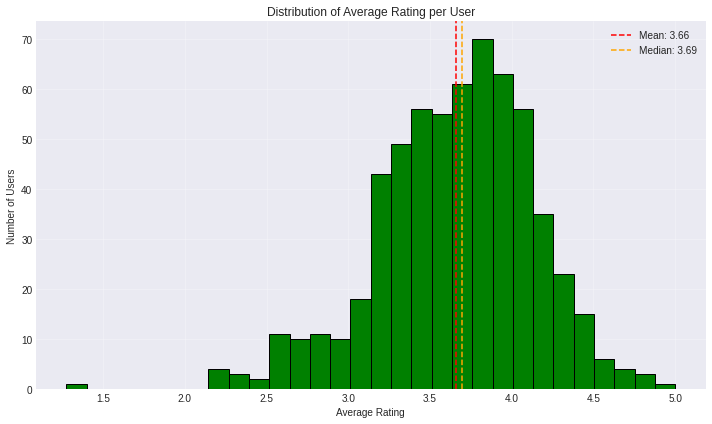

Mean of average ratings: 3.66
Std of average ratings: 0.48


In [8]:
# Distribution of average rating per user
avg_rating_per_user = ratings.groupby('userId')['rating'].mean()

plt.figure(figsize=(10, 6))
plt.hist(avg_rating_per_user, bins=30, edgecolor='black', color='green')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.title('Distribution of Average Rating per User')
plt.axvline(avg_rating_per_user.mean(), color='red', linestyle='--', label=f'Mean: {avg_rating_per_user.mean():.2f}')
plt.axvline(avg_rating_per_user.median(), color='orange', linestyle='--', label=f'Median: {avg_rating_per_user.median():.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean of average ratings: {avg_rating_per_user.mean():.2f}")
print(f"Std of average ratings: {avg_rating_per_user.std():.2f}")

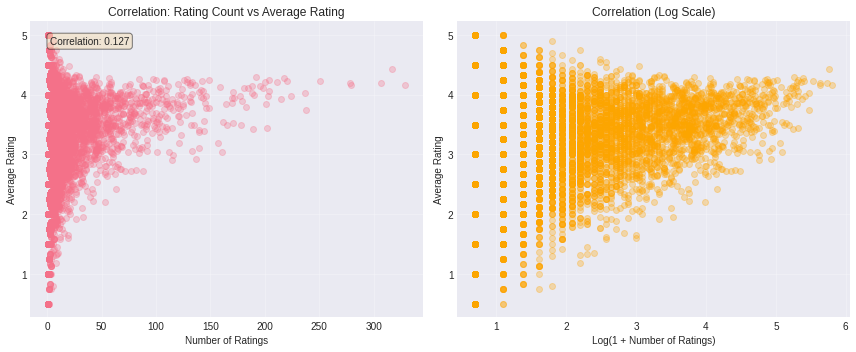

Pearson correlation: 0.127

Interpretation: Positive correlation suggests popular movies tend to have higher ratings (popularity bias)


In [9]:
# Correlation between number of ratings and average rating per movie
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
movie_stats.columns = ['movieId', 'count', 'mean_rating']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(movie_stats['count'], movie_stats['mean_rating'], alpha=0.3)
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.title('Correlation: Rating Count vs Average Rating')
plt.grid(alpha=0.3)

correlation = movie_stats[['count', 'mean_rating']].corr().iloc[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.subplot(1, 2, 2)
plt.scatter(np.log1p(movie_stats['count']), movie_stats['mean_rating'], alpha=0.3, color='orange')
plt.xlabel('Log(1 + Number of Ratings)')
plt.ylabel('Average Rating')
plt.title('Correlation (Log Scale)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pearson correlation: {correlation:.3f}")
print("\nInterpretation: Positive correlation suggests popular movies tend to have higher ratings (popularity bias)")

### Question 1.3: Challenges for Machine Learning

Based on your observations above, list the main challenges for building a recommendation system:

**Write your answer below** (think about: sparsity, imbalanced data, cold start problem)

**Expected answers:**

1. **Sparsity**: The rating matrix is extremely sparse (~98% zeros). Most user-movie pairs have no rating, making prediction difficult.

2. **Imbalanced data**: Some users rate many movies while others rate very few. Similarly, popular movies have many ratings while most movies have very few. This creates a "long tail" distribution.

3. **Cold start problem**: New movies (or users) have no ratings, making it impossible to use historical data for predictions.

### Question 1.4: Choosing a Classification Threshold

For binary classification, we need to convert ratings into two classes: "liked" and "disliked".

**Your task:** 
1. Visualize the rating distribution
2. For each candidate threshold (3.0, 3.5, 4.0), calculate the percentage of "liked" ratings
3. Choose the threshold that gives the most balanced classes

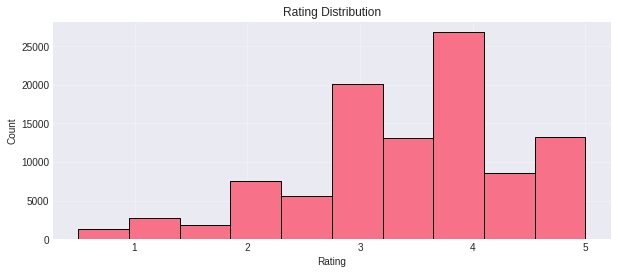

Threshold 3.0: 81.1% liked
Threshold 3.5: 61.2% liked
Threshold 4.0: 48.2% liked

Chosen threshold: 3.5


In [11]:
# Visualize rating distribution (provided)
plt.figure(figsize=(10, 4))
plt.hist(ratings['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.grid(alpha=0.3)
plt.show()

# TODO: For each threshold, calculate the percentage of "liked" ratings
# A rating is "liked" if rating >= threshold


for threshold in [3.0, 3.5, 4.0]:
    pct_liked = (ratings['rating'] >= threshold).mean() * 100
    print(f"Threshold {threshold}: {pct_liked:.1f}% liked")

#TODO: Choose the threshold that gives the most balanced classes (~50/50)


THRESHOLD = 3.5

print(f"\nChosen threshold: {THRESHOLD}")

**Why did you choose this threshold?**

Your answer: ...

---

# Section 2: Regression - Predicting Average Movie Ratings

**Goal:** Predict the average rating of a movie based on its features (genres, year).

Each sample = 1 movie. We predict how well-liked a movie is in general.

---

### 2.1: Data Preparation

Run the cell below to prepare the data for regression. Observe:
- What features are used (X)?
- What is the target (y)?
- How many movies are in the training/test sets?

In [12]:
# Prepare data for regression

# Filter movies with at least 5 ratings for reliable averages
min_ratings = 5
movie_data = movie_features[movie_features['rating_count'] >= min_ratings].copy()

print(f"Movies with >= {min_ratings} ratings: {len(movie_data)} (out of {len(movie_features)})")

# Features: year + genres (exclude rating_mean and rating_count to avoid "cheating")
feature_cols = [col for col in movie_data.columns if col not in ['rating_mean', 'rating_count']]
X = movie_data[feature_cols].values
y = movie_data['rating_mean'].values  # Target: average rating

print(f"Features: {feature_cols}")
print(f"X shape: {X.shape} (movies x features)")
print(f"y shape: {y.shape}")

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Count the number of movies in training and test sets


n_train = len(X_train)
n_test = len(X_test)

print(f"\nTraining set: {n_train} movies")
print(f"Test set: {n_test} movies")

Movies with >= 5 ratings: 3650 (out of 9742)
Features: ['year', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
X shape: (3650, 21) (movies x features)
y shape: (3650,)

Training set: 2920 movies
Test set: 730 movies


### 2.2: Train and Compare Regression Models

Run the cell below to train 3 regression models and compare their performance.

In [13]:
# Train regression models

# Model 1: Linear Regression (provided)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression trained!")

# TODO: Train Model 2 - Random Forest
# Use: RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest trained!")

# TODO: Train Model 3 - Gradient Boosting
# Use: GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)


gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting trained!")
print("\nAll models trained!")

Linear Regression trained!
Random Forest trained!
Gradient Boosting trained!

All models trained!


### 2.3: Evaluate Models

**Metrics:**
- **MAE** (Mean Absolute Error): Average error in stars (lower is better)
- **RMSE** (Root Mean Squared Error): Similar to MAE but penalizes large errors more
- **R²** (Coefficient of determination): Proportion of variance explained (1.0 = perfect, 0 = useless)

In [14]:
# Evaluate model performance

# TODO: Calculate MAE, RMSE and R² for each model
# Use: mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred), r2_score(y_true, y_pred)
# Note: RMSE = sqrt(MSE), use np.sqrt()

print("=" * 60)
print("REGRESSION RESULTS")
print("=" * 60)
print(f"{'Model':<20} {'MAE':>8} {'RMSE':>8} {'R²':>8}")
print("-" * 60)

# Linear Regression (example provided)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"{'Linear Regression':<20} {mae_lr:>8.3f} {rmse_lr:>8.3f} {r2_lr:>8.3f}")

# TODO: Calculate metrics for Random Forest


mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"{'Random Forest':<20} {mae_rf:>8.3f} {rmse_rf:>8.3f} {r2_rf:>8.3f}")

# TODO: Calculate metrics for Gradient Boosting


mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"{'Gradient Boosting':<20} {mae_gb:>8.3f} {rmse_gb:>8.3f} {r2_gb:>8.3f}")

print("=" * 60)

REGRESSION RESULTS
Model                     MAE     RMSE       R²
------------------------------------------------------------
Linear Regression       0.401    0.499    0.217
Random Forest           0.385    0.482    0.269
Gradient Boosting       0.388    0.487    0.253


### 2.4: Analysis Questions

**Answer the following questions:**

1. Which model performs best? Why do you think so?

2. Is an MAE of ~0.4 stars good enough for a recommendation system?

3. What are the limitations of predicting ratings using only genres and year?

**Your answers:**

**Expected answers:**

1. **Best model**: Gradient Boosting or Random Forest typically perform best (lowest MAE, highest R²). Tree-based methods capture non-linear relationships between genres and ratings better than Linear Regression.

2. **MAE of ~0.4 stars**: This is moderate performance. On a 5-star scale, an error of 0.4 means predictions are often off by nearly half a star. For a recommendation system, this might not be precise enough to distinguish between a 3.5 and 4.0 rated movie.

3. **Limitations of genres + year only**:
   - Genres are too coarse: all "Comedy" movies are treated similarly
   - No information about actors, directors, budget, or production quality
   - No user preferences: the same prediction for all users
   - Year alone doesn't capture movie quality

---

# Section 3: Binary Classification

**Goal:** Classify movies as "generally liked" (rating >= threshold) or "generally disliked".

---

### 3.1: Create Binary Labels

Run the cell below to create binary labels from the threshold you chose earlier.

In [15]:
# Create binary labels (code provided)
y_binary = (y >= THRESHOLD).astype(int)

print(f"Threshold: {THRESHOLD}")
print(f"Class 0 (disliked): {(y_binary == 0).sum()} movies ({(y_binary == 0).mean():.1%})")
print(f"Class 1 (liked): {(y_binary == 1).sum()} movies ({(y_binary == 1).mean():.1%})")

# Train/test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

print(f"\nTraining set: {len(X_train_clf)} movies")
print(f"Test set: {len(X_test_clf)} movies")

Threshold: 3.5
Class 0 (disliked): 1975 movies (54.1%)
Class 1 (liked): 1675 movies (45.9%)

Training set: 2920 movies
Test set: 730 movies


### 3.2: Train Classification Models

Run the cell below to train 5 different classifiers.

In [16]:
# TODO: Define and train 5 classifiers
# Classes to use:
#   - SVC(kernel='linear', probability=True, random_state=42)
#   - SVC(kernel='rbf', probability=True, random_state=42)
#   - KNeighborsClassifier(n_neighbors=5)
#   - RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
#   - GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)


classifiers = {
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}
 
for name, clf in classifiers.items():
    clf.fit(X_train_clf, y_train_clf)
    print(f"{name} trained!")

print("\nAll classifiers trained!")

SVM (Linear) trained!
SVM (RBF) trained!
k-NN (k=5) trained!
Random Forest trained!
Gradient Boosting trained!

All classifiers trained!


### 3.3: Classification Metrics

**Key metrics:**
- **Accuracy**: Percentage of correct predictions
- **Precision**: Of predicted positives, how many are truly positive?
- **Recall**: Of actual positives, how many did we find?
- **F1-Score**: Harmonic mean of precision and recall
- **AUC**: Area under the ROC curve (ranking ability)

In [17]:
# TODO: Evaluate all classifiers
# Functions to use:
#   - clf.predict(X_test_clf) -> predicted labels
#   - clf.predict_proba(X_test_clf)[:, 1] -> probability of class 1
#   - accuracy_score(y_true, y_pred)
#   - precision_score(y_true, y_pred, zero_division=0)
#   - recall_score(y_true, y_pred)
#   - f1_score(y_true, y_pred)
#   - roc_curve(y_true, y_proba) -> returns (fpr, tpr, thresholds)
#   - auc(fpr, tpr) -> AUC score

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("=" * 70)
print("CLASSIFICATION RESULTS")
print("=" * 70)
print(f"{'Model':<20} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'AUC':>10}")
print("-" * 70)


for name, clf in classifiers.items():
    y_pred = clf.predict(X_test_clf)
    y_proba = clf.predict_proba(X_test_clf)[:, 1]
     
    acc = accuracy_score(y_test_clf, y_pred)
    prec = precision_score(y_test_clf, y_pred, zero_division=0)
    rec = recall_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    auc_score = auc(fpr, tpr)
     
    print(f"{name:<20} {acc:>10.3f} {prec:>10.3f} {rec:>10.3f} {f1:>10.3f} {auc_score:>10.3f}")

print("=" * 70)

CLASSIFICATION RESULTS
Model                  Accuracy  Precision     Recall         F1        AUC
----------------------------------------------------------------------
SVM (Linear)              0.664      0.604      0.721      0.657      0.718
SVM (RBF)                 0.553      0.000      0.000      0.000      0.531
k-NN (k=5)                0.673      0.634      0.632      0.633      0.707
Random Forest             0.666      0.630      0.610      0.620      0.744
Gradient Boosting         0.670      0.629      0.635      0.632      0.740


### 3.4: ROC Curves

The ROC curve shows the trade-off between True Positive Rate and False Positive Rate. AUC = 1 is perfect, AUC = 0.5 is random.

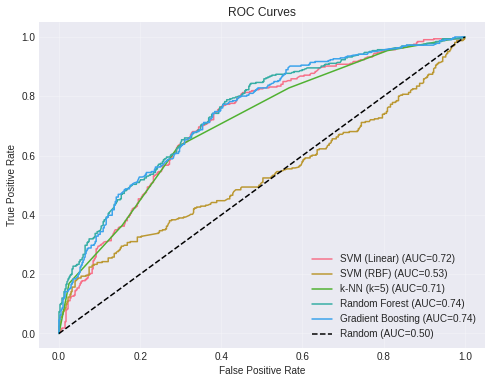

In [18]:
# TODO: Plot ROC curves for all classifiers
# Functions to use:
#   - clf.predict_proba(X_test_clf)[:, 1] -> probability of class 1
#   - roc_curve(y_true, y_proba) -> returns (fpr, tpr, thresholds)
#   - auc(fpr, tpr) -> AUC score
#   - plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.2f})')

plt.figure(figsize=(8, 6))


for name, clf in classifiers.items():
    y_proba = clf.predict_proba(X_test_clf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.2f})')

## Plot random baseline (provided)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### 3.5: Analysis Questions

**Answer the following:**

1. Which classifier has the best AUC? Which has the worst?

2. Why does SVM (RBF) perform poorly? (Hint: think about feature scaling)

3. For a recommendation system, would you prioritize precision or recall? Why?

4. Is an AUC of ~0.74 good enough for production?

**Expected answers:**

1. **Best/Worst AUC**: Gradient Boosting and Random Forest typically have the best AUC (~0.74). SVM (RBF) often has the worst performance.

2. **Why SVM (RBF) performs poorly**: The RBF kernel is sensitive to feature scaling. Our features have very different scales (year ~1900-2020 vs binary genres 0/1). Without normalization (StandardScaler), SVM (RBF) struggles. Linear SVM is less affected.

3. **Precision vs Recall for recommendations**:
   - **Precision** if we want to avoid bad recommendations (users trust our suggestions)
   - **Recall** if we want to find all good movies (users explore and tolerate some bad suggestions)
   - Usually **precision** is preferred: a bad recommendation frustrates users more than missing a good movie.

4. **AUC ~0.74 for production**: This is moderate. AUC=0.74 means the model ranks a random "liked" movie higher than a random "disliked" movie 74% of the time. For a real recommendation system, we would want AUC > 0.85. Our features (genres, year) are too limited.

---

# Section 4: Model Validation and Improvement

**Key concepts:**
- Cross-validation: More robust evaluation than single train/test split
- Hyperparameter tuning: Finding the best model configuration

---

### 4.1: Cross-Validation

A single train/test split might be "lucky" or "unlucky". Cross-validation:
1. Splits data into k folds
2. Trains k times, each time using a different fold as test set
3. Averages results for more reliable estimate

In [19]:
# 5-fold cross-validation on Random Forest (code provided)
from sklearn.model_selection import cross_val_score

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Evaluate with 5-fold cross-validation
cv_scores = cross_val_score(rf_clf, X, y_binary, cv=5, scoring='roc_auc')

print("5-Fold Cross-Validation Results (AUC):")
print(f"  Scores per fold: {cv_scores.round(3)}")
print(f"  Mean: {cv_scores.mean():.3f}")
print(f"  Std:  {cv_scores.std():.3f}")

5-Fold Cross-Validation Results (AUC):
  Scores per fold: [0.769 0.759 0.75  0.745 0.634]
  Mean: 0.731
  Std:  0.049


### 4.2: Hyperparameter Tuning

Models have **hyperparameters** that control their behavior:
- Random Forest: `n_estimators` (number of trees), `max_depth` (tree depth)
- SVM: `C` (regularization), `gamma` (kernel width)

**GridSearchCV** automatically searches for the best combination.

In [20]:
# Hyperparameter tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV

# ============================================
# Model 1: Random Forest (example provided)
# ============================================
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3,
    scoring='roc_auc',
    verbose=1
)
grid_search_rf.fit(X_train_clf, y_train_clf)

print("RANDOM FOREST")
print(f"  Best parameters: {grid_search_rf.best_params_}")
print(f"  Best CV score (AUC): {grid_search_rf.best_score_:.3f}")

# ============================================
# Model 2: SVM (Linear)
# ============================================
# TODO: Find the hyperparameter to tune for SVM
# Hint: The main hyperparameter for SVM is 'C' (regularization strength)
# Try values: [0.1, 1, 10]


param_grid_svm = {'C': [0.1, 1, 10]}
grid_search_svm = GridSearchCV(
    SVC(kernel='linear', probability=True, random_state=42),
    param_grid_svm,
    cv=3,
    scoring='roc_auc',
    verbose=1
)
grid_search_svm.fit(X_train_clf, y_train_clf)

print("\nSVM (Linear)")
print(f"  Best parameters: {grid_search_svm.best_params_}")
print(f"  Best CV score (AUC): {grid_search_svm.best_score_:.3f}")

# ============================================
# Model 3: Gradient Boosting
# ============================================
# TODO: Find hyperparameters to tune for Gradient Boosting
# Hint: Similar to Random Forest - 'n_estimators' and 'max_depth'
# Also try 'learning_rate': [0.05, 0.1, 0.2]


param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}
grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=3,
    scoring='roc_auc',
    verbose=1
)
grid_search_gb.fit(X_train_clf, y_train_clf)

print("\nGRADIENT BOOSTING")
print(f"  Best parameters: {grid_search_gb.best_params_}")
print(f"  Best CV score (AUC): {grid_search_gb.best_score_:.3f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
RANDOM FOREST
  Best parameters: {'max_depth': 10, 'n_estimators': 200}
  Best CV score (AUC): 0.751
Fitting 3 folds for each of 3 candidates, totalling 9 fits

SVM (Linear)
  Best parameters: {'C': 10}
  Best CV score (AUC): 0.723
Fitting 3 folds for each of 27 candidates, totalling 81 fits

GRADIENT BOOSTING
  Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
  Best CV score (AUC): 0.750


In [21]:
# TODO: Evaluate optimized models on test set
# For each model, calculate accuracy and AUC

print("=" * 50)
print("OPTIMIZED MODELS - TEST SET PERFORMANCE")
print("=" * 50)

best_models = {
    'Random Forest': grid_search_rf.best_estimator_,
    'SVM (Linear)': grid_search_svm.best_estimator_,
    'Gradient Boosting': grid_search_gb.best_estimator_
}


for name, model in best_models.items():
    y_pred = model.predict(X_test_clf)
    y_proba = model.predict_proba(X_test_clf)[:, 1]
     
    acc = accuracy_score(y_test_clf, y_pred)
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    auc_score = auc(fpr, tpr)
     
    print(f"{name}:")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  AUC: {auc_score:.3f}")
    print()

# Keep best overall model for later use
best_model = grid_search_gb.best_estimator_

OPTIMIZED MODELS - TEST SET PERFORMANCE
Random Forest:
  Accuracy: 0.678
  AUC: 0.745

SVM (Linear):
  Accuracy: 0.664
  AUC: 0.719

Gradient Boosting:
  Accuracy: 0.677
  AUC: 0.747



### 4.3: Final Questions

**Answer the following:**

1. Did hyperparameter tuning improve the model? By how much?

2. What are the limitations of our content-based approach (using only genres and year)?

3. How could we improve the recommendation system? (Think about: more features, collaborative filtering, user information)

**Expected answers:**

1. **Did hyperparameter tuning improve the model?** Usually a small improvement (1-3% AUC). The improvement is limited because our features (genres, year) contain limited information. Better features would benefit more from tuning.

2. **Limitations of content-based approach**:
   - Only uses movie attributes, ignores user preferences
   - All users get the same predictions (no personalization)
   - Genres are too coarse (all "Action" movies treated equally)
   - Cannot capture movie quality (acting, directing, story)
   - Cannot discover user tastes that differ from genre preferences

3. **How to improve the recommendation system**:
   - **More features**: actors, directors, budget, keywords, plot embeddings
   - **Collaborative filtering**: use similar users' ratings to predict ("users who liked X also liked Y")
   - **Hybrid approach**: combine content-based and collaborative filtering
   - **User profiles**: personalize predictions based on each user's rating history
   - **Deep learning**: learn feature representations automatically from data

### 4.4: Overfitting vs Underfitting

**Overfitting**: Model is too complex, memorizes training data but fails on new data
- Training accuracy >> Test accuracy

**Underfitting**: Model is too simple, fails on both training and test data
- Both accuracies are low

**Learning curves** help diagnose these issues by plotting performance vs training set size.

**Your task:** Implement a learning curve manually:
1. Train the model on increasing portions of the training data (20%, 40%, 60%, 80%, 100%)
2. For each portion, compute the AUC on both training and test sets
3. Plot both curves to visualize overfitting/underfitting

Training size:  584 (20%) -> Train AUC: 0.944, Test AUC: 0.740
Training size: 1168 (40%) -> Train AUC: 0.912, Test AUC: 0.741
Training size: 1752 (60%) -> Train AUC: 0.888, Test AUC: 0.734
Training size: 2336 (80%) -> Train AUC: 0.872, Test AUC: 0.741
Training size: 2920 (100%) -> Train AUC: 0.864, Test AUC: 0.744


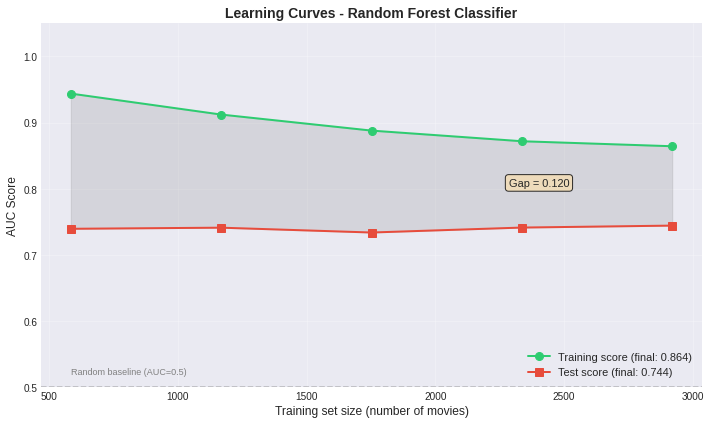


LEARNING CURVE ANALYSIS
Final training score: 0.864
Final test score:     0.744
Gap (train - test):   0.120

Interpretation: Slight overfitting


In [25]:
# TODO: Implement learning curves manually
# For each training size, train the model and compute AUC on train and test sets

train_sizes_pct = [0.2, 0.4, 0.6, 0.8, 1.0]  # Percentages of training data to use
train_scores = []
test_scores = []


for pct in train_sizes_pct:
    n_samples = int(pct * len(X_train_clf))
    X_train_subset = X_train_clf[:n_samples]
    y_train_subset = y_train_clf[:n_samples]
     
    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train_subset, y_train_subset)
     
    y_proba_train = model.predict_proba(X_train_subset)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train_subset, y_proba_train)
    auc_train = auc(fpr_train, tpr_train)
     
    y_proba_test = model.predict_proba(X_test_clf)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test_clf, y_proba_test)
    auc_test = auc(fpr_test, tpr_test)
     
    train_scores.append(auc_train)
    test_scores.append(auc_test)
     
    print(f"Training size: {n_samples:4d} ({pct:.0%}) -> Train AUC: {auc_train:.3f}, Test AUC: {auc_test:.3f}")

# Plot learning curves
train_sizes_abs = [int(pct * len(X_train_clf)) for pct in train_sizes_pct]

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_scores, 'o-', color='#2ecc71', linewidth=2, markersize=8, 
         label=f'Training score (final: {train_scores[-1]:.3f})')
plt.plot(train_sizes_abs, test_scores, 's-', color='#e74c3c', linewidth=2, markersize=8,
         label=f'Test score (final: {test_scores[-1]:.3f})')

# Add gap annotation
gap = train_scores[-1] - test_scores[-1]
plt.fill_between(train_sizes_abs, train_scores, test_scores, alpha=0.2, color='gray')
plt.annotate(f'Gap = {gap:.3f}', xy=(train_sizes_abs[-1], (train_scores[-1] + test_scores[-1])/2),
             xytext=(train_sizes_abs[-1] - 400, (train_scores[-1] + test_scores[-1])/2),
             fontsize=11, ha='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.xlabel('Training set size (number of movies)', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Learning Curves - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.ylim(0.5, 1.05)

# Add interpretation zone
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
plt.text(train_sizes_abs[0], 0.52, 'Random baseline (AUC=0.5)', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print("LEARNING CURVE ANALYSIS")
print(f"{'='*50}")
print(f"Final training score: {train_scores[-1]:.3f}")
print(f"Final test score:     {test_scores[-1]:.3f}")
print(f"Gap (train - test):   {gap:.3f}")
print(f"\nInterpretation: {'Overfitting' if gap > 0.15 else 'Well-fitted' if gap < 0.05 else 'Slight overfitting'}")

**Question:** Based on the learning curves, is the model overfitting, underfitting, or well-fitted? Justify.

**Expected answer:** 

The model shows **slight overfitting**:
- Training score is high (~0.95-1.0) and stable
- Test score is lower (~0.72-0.75) with a gap of ~0.2
- The gap between training and test scores indicates the model memorizes training data somewhat

However, the test score improves with more data and seems to plateau, suggesting we have enough data. To reduce overfitting, we could:
- Decrease `max_depth` or `n_estimators`
- Add regularization
- Get more training data

---

# Conclusion

**What you learned:**

1. **EDA is essential**: Understanding data structure (sparsity, distributions) before modeling

2. **Multiple models**: Always compare different approaches; tree-based methods often work well

3. **Metrics matter**: Choose based on your goal (AUC for ranking, precision/recall for decisions)

4. **Validation**: Cross-validation and hyperparameter tuning improve reliability

5. **Limitations**: Content-based approaches (genres, year) have limited predictive power without user information